## Residual dependence on host galaxy properties

### Find Host Galaxy for a SN
We set a maximum distance 1.0 arcsec between the SN and its host galaxy.

In [7]:
import pickle
import numpy as np
max_dist_arcsec = 1.0
with open("./post_data/valid_host_galaxies.pkl","rb") as f:
    data = pickle.load(f)

SN_sample = data["SN_sample"]
valid_SN_ids = data["valid_SN_ids"]
valid_host_galaxies = data["valid_host_galaxies"]

In [8]:
# Check one
valid_host_galaxies[780] # ID column corresponds to ID in SN_sample, dist is the angular distance between the SN and galaxy in arcsec, type is the galaxy type

ID,release,brickid,brickname,objid,brick_primary,maskbits,fitbits,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq,ebv,mjd_min,mjd_max,ref_cat,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_bp_n_obs,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_astrometric_weight_al,gaia_duplicated_source,gaia_a_g_val,gaia_e_bp_min_rp_val,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,apflux_g,apflux_r,apflux_z,apflux_resid_g,apflux_resid_r,apflux_resid_z,apflux_blobresid_g,apflux_blobresid_r,apflux_blobresid_z,apflux_ivar_g,apflux_ivar_r,apflux_ivar_z,apflux_masked_g,apflux_masked_r,apflux_masked_z,apflux_w1,apflux_w2,apflux_w3,apflux_w4,apflux_resid_w1,apflux_resid_w2,apflux_resid_w3,apflux_resid_w4,apflux_ivar_w1,apflux_ivar_w2,apflux_ivar_w3,apflux_ivar_w4,mw_transmission_g,mw_transmission_r,mw_transmission_z,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_g,nobs_r,nobs_z,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_g,fracflux_r,fracflux_z,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_g,fracmasked_r,fracmasked_z,fracin_g,fracin_r,fracin_z,anymask_g,anymask_r,anymask_z,allmask_g,allmask_r,allmask_z,wisemask_w1,wisemask_w2,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,nea_g,nea_r,nea_z,blob_nea_g,blob_nea_r,blob_nea_z,psfdepth_w1,psfdepth_w2,psfdepth_w3,psfdepth_w4,wise_coadd_id,wise_x,wise_y,lc_flux_w1,lc_flux_w2,lc_flux_ivar_w1,lc_flux_ivar_w2,lc_nobs_w1,lc_nobs_w2,lc_fracflux_w1,lc_fracflux_w2,lc_rchisq_w1,lc_rchisq_w2,lc_mjd_w1,lc_mjd_w2,lc_epoch_index_w1,lc_epoch_index_w2,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,dist,excluded_count,dr
int64,int16,int32,bytes8,int32,bool,int16,int16,bytes3,float64,float64,float32,float32,float32,float32,float32[5],float32,float64,float64,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32[15],float32[15],float32[15],float32[15],int16[15],int16[15],float32[15],float32[15],float32[15],float32[15],float64[15],float64[15],int16[15],int16[15],float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64
1245,9010,167938,0551m295,233,True,0,0,REX,55.03552935874508,-29.436677333779645,2.2864891e+11,2.346893e+1

Omega_m = 0.3289 +0.0152 -0.0143
M       = 5.0080 +0.0100 -0.0102


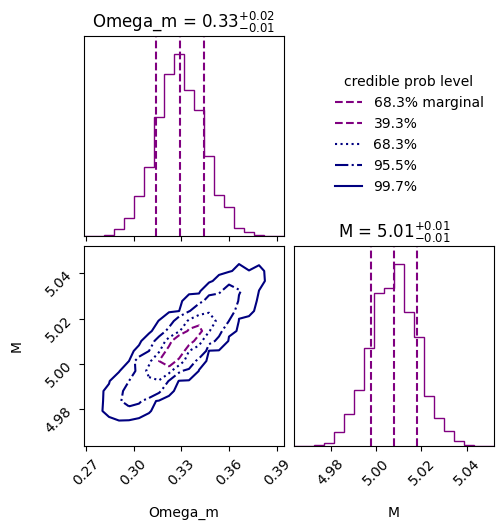

In [9]:
# analysis with FLCDM
from ultranest.plot import cornerplot
from ultranest.utils import resample_equal

with open(f'fits/Flat_LCDM_wide_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)

cornerplot(Flat_LCDM_result)

# Extract weighted posterior
samples   = Flat_LCDM_result["weighted_samples"]["points"]
weights   = Flat_LCDM_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16,       M_q50,       M_q84       = np.percentile(equal_samples[:, 1], [16, 50, 84])

print(f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
      f"-{Omega_m_q50 - Omega_m_q16:.4f}")
print(f"M       = {M_q50:.4f} +{M_q84 - M_q50:.4f} "
      f"-{M_q50 - M_q16:.4f}")

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z) function."""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """
    Flat w0waCDM: E(z) function. Using CPL paramerization: w(z) = w0 + wa * z/(1+z).
    """
    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Open ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                Omega_k: Curvature density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # Comoving transverse distance
    if Omega_k == 0:
        dM = dC
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat wCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w: Dark energy equation of state parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat w0waCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w0: Dark energy equation of state parameter at z=0
                wa: Evolution parameter of dark energy equation of state
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_w0waCDM(z_prime, Omega_m, w0, wa)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Distance modulus for various cosmological models.

    Parameters:
        z: Redshift
        params: Model parameters (tuple)
        model: Cosmological model. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        Distance Modulus (mu)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Invalid model: {model}. Valid models: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

In [13]:
model = 'Flat_LCDM'
z_all = SN_sample['zHD'].data
mu_obs_all = SN_sample['MU'].data

# Model distance modulus for Flat ΛCDM
mu_model_all = np.array([
    distance_modulus(z, [Omega_m_q50], model=model) + M_q50
    for z in z_all
])

# Hubble residuals: Δμ = μ_obs − μ_model
residual_all = mu_obs_all - mu_model_all

### 形态分析

/tmp/ipykernel_251937/1619470795.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='residual', data=df_type, palette="Set2", order=['EXP', 'DEV', 'SER', 'REX'])


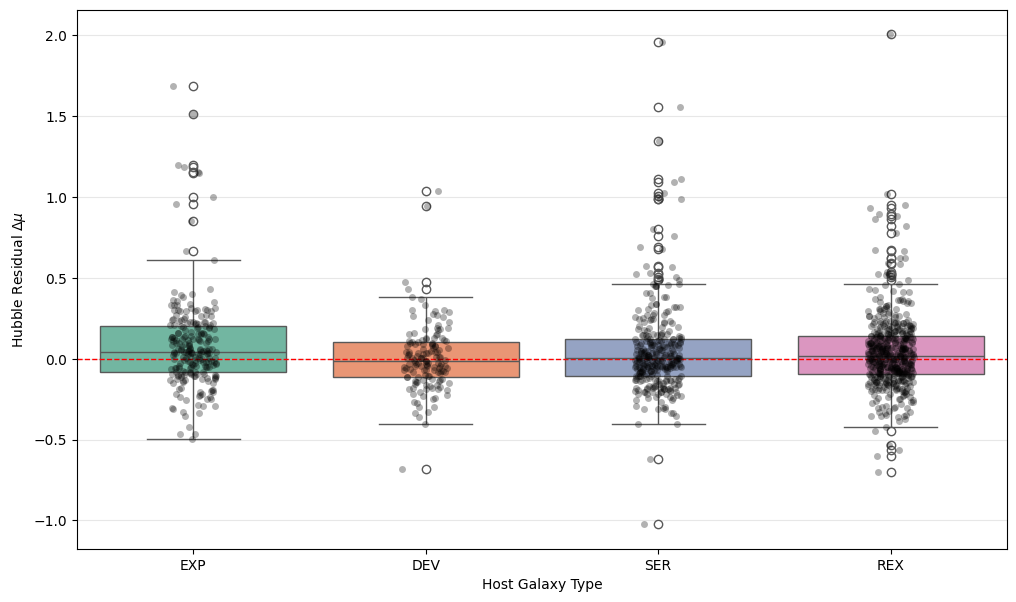

Summary Statistics by Type:
  type  count      mean       std    median
0  DEV    145  0.007668  0.210194 -0.012110
1  EXP    231  0.087362  0.295181  0.041957
2  REX    503  0.041109  0.236927  0.019351
3  SER    317  0.054146  0.295546  0.003105

ANOVA test p-value: 2.8435e-02


In [14]:

#提取数据
SN_ids_type = []
host_types = []
res_values = []


for host in valid_host_galaxies:
    SN_id = host['ID'][0]
    
    # 提取形态类型 (EXP, DEV, SER, REX)
    # 注意：Tractor目录中的 type 可能是 bytes 类型，需要 decode
    h_type = host['type'][0]
    if isinstance(h_type, bytes):
        h_type = h_type.decode('utf-8').strip()
    else:
        h_type = str(h_type).strip()

    # 过滤掉 PSF (恒星) 或 异常分类
    if h_type in ['PSF', 'DUP', '']:
        continue

    SN_ids_type.append(SN_id)
    host_types.append(h_type)
    res_values.append(residual_all[SN_id])

# 转换为 DataFrame 
df_type = pd.DataFrame({
    'type': host_types,
    'residual': res_values
})

# --- 第二步：可视化 ---
plt.figure(figsize=(12, 7))

# 使用 Seaborn 画箱线图
sns.boxplot(x='type', y='residual', data=df_type, palette="Set2", order=['EXP', 'DEV', 'SER', 'REX'])

# 叠加散点图，观察样本分布（可选）
sns.stripplot(x='type', y='residual', data=df_type, color='black', alpha=0.3, jitter=True)

plt.axhline(0, color='red', linestyle='--', linewidth=1) # 理论 0 线
plt.xlabel('Host Galaxy Type')
plt.ylabel(r'Hubble Residual $\Delta\mu$')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- 第三步：数值汇总 ---
summary = df_type.groupby('type')['residual'].agg(['count', 'mean', 'std', 'median']).reset_index()
print("Summary Statistics by Type:")
print(summary)

# --- 第四步：显著性检验 (ANOVA) ---
# 检查不同组之间的均值是否真的有统计学上的显著差异
groups = [df_type[df_type['type'] == t]['residual'] for t in df_type['type'].unique()]
f_val, p_val = stats.f_oneway(*groups)
print(f"\nANOVA test p-value: {p_val:.4e}")

CMT: 不同星系形态也许会影响残差

### 半光半径与残差分析

In [15]:

shape_r_values =[]
res_for_shape = []
types_for_shape = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]
    h_type = host['type'][0]
    if isinstance(h_type, bytes): h_type = h_type.decode('utf-8').strip()
    
    # 排除点源(PSF)，因为它们的 shape_r 通常为 0 或无效
    if h_type != 'PSF' and host['shape_r'][0] > 0:
        shape_r_values.append(host['shape_r'][0])
        res_for_shape.append(residual_all[SN_id])
        types_for_shape.append(h_type)

df_shape = pd.DataFrame({
    'shape_r': shape_r_values,
    'residual': res_for_shape,
    'type': types_for_shape,
    'log_r': np.log10(shape_r_values) 
})

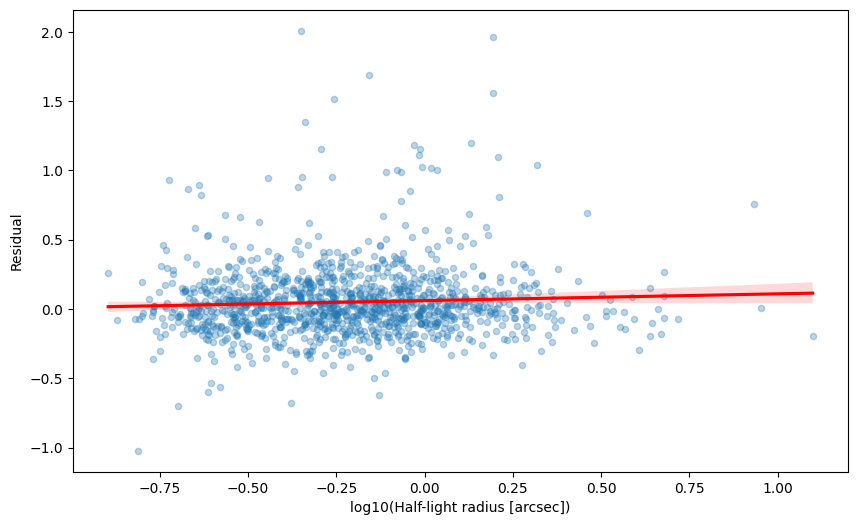

Pearson: 0.0555, p-value: 5.50e-02


In [16]:
plt.figure(figsize=(10, 6))
sns.regplot(x='log_r', y='residual', data=df_shape, 
            scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'red'})
plt.xlabel('log10(Half-light radius [arcsec])')
plt.ylabel('Residual')
plt.show()

r, p = stats.pearsonr(df_shape['log_r'], df_shape['residual'])
print(f"Pearson: {r:.4f}, p-value: {p:.2e}")

CMT: 看起来半光半径也没有相关性, 但 p 值在临界范围, 不好下结论

### 椭率分析

0.08145496031075235 0.004821628206677809


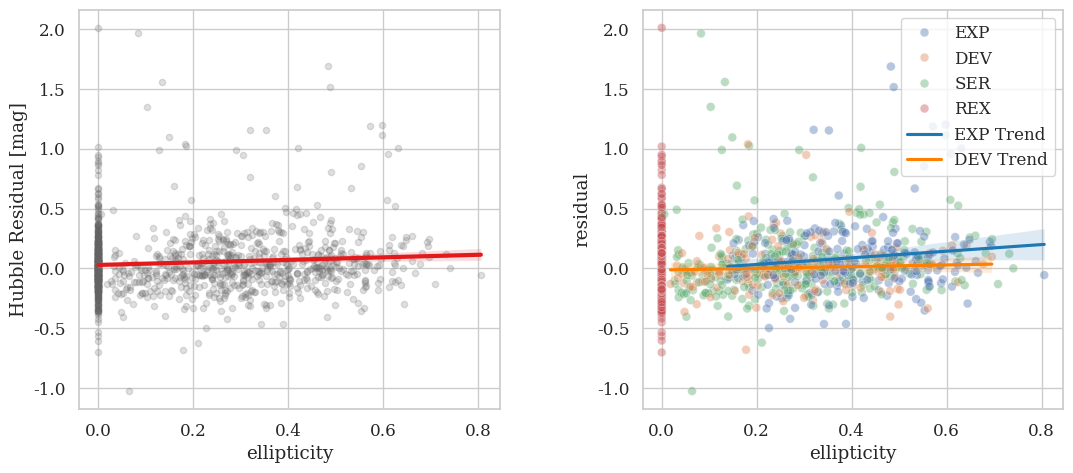


Ellipticity Bin      | Count  | Mean Res  
----------------------------------------
0.0 (Round)          | 503    | 0.0411
0.01-0.24            | 231    | 0.0265
0.24-0.40            | 231    | 0.0438
0.40-0.81            | 231    | 0.0962


In [17]:
# --- 1. 设置全局绘图风格  ---
sns.set_theme(style="whitegrid", font="serif", font_scale=1.1)
plt.rcParams['axes.unicode_minus'] = False 

# --- 2. 数据提取 ---
ellip_data, res_data, type_data = [], [], []
for host in valid_host_galaxies:
    SN_id = host['ID'][0]
    h_type = host['type'][0]
    if isinstance(h_type, bytes): h_type = h_type.decode('utf-8').strip()
    if h_type != 'PSF':
        e1, e2 = host['shape_e1'][0], host['shape_e2'][0]
        eps = np.sqrt(e1**2 + e2**2)
        if 0 <= eps <= 1.0:
            ellip_data.append(eps)
            res_data.append(residual_all[SN_id])
            type_data.append(h_type)

df = pd.DataFrame({'ellipticity': ellip_data, 'residual': res_data, 'type': type_data})

# --- 3. 修正后的分箱逻辑  ---
df_zero = df[df['ellipticity'] == 0].copy()
df_nonzero = df[df['ellipticity'] > 0].copy()

# 对非零部分进行等频分箱并获取边界
_, bin_edges = pd.qcut(df_nonzero['ellipticity'], 3, retbins=True)

# 手动构建整洁的标签
def format_labels(edges):
    return [f"{edges[i]:.2f}-{edges[i+1]:.2f}" for i in range(len(edges)-1)]

nonzero_labels = format_labels(bin_edges)
df_nonzero['bin'] = pd.qcut(df_nonzero['ellipticity'], 3, labels=nonzero_labels).astype(str)
df_zero['bin'] = '0.0 (Round)'

df_plot = pd.concat([df_zero, df_nonzero])
bin_order = ['0.0 (Round)'] + nonzero_labels

# --- 4. 绘制规整的 2x2 组合图 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 图 A: 椭率分布 - 使用原始字符串 r'' 解决 SyntaxWarning
# sns.histplot(df['ellipticity'], bins=25, kde=True, color='#2c7fb8', ax=axes[0,0])
# axes[0,0].set_xlabel(r'Ellipticity ($\epsilon$)') # 使用 r 解决警告

# 图 B: 整体回归趋势
sns.regplot(x='ellipticity', y='residual', data=df, ax=axes[0], 
            scatter_kws={'alpha':0.2, 'color':'#636363', 's':20}, 
            line_kws={'color':'#e31a1c', 'lw':3})
r, p = stats.pearsonr(df['ellipticity'], df['residual'])
axes[0].set_ylabel('Hubble Residual [mag]')
print(r,p)

# 图 C: 分箱箱线图 
# sns.boxplot(x='bin', y='residual', data=df_plot, order=bin_order, 
#             hue='bin', palette="GnBu", ax=axes[1,0], width=0.5, legend=False)
# axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.6)
# axes[1,0].set_xlabel(r'Ellipticity Intervals ($\epsilon$)')
# # 修复 set_xticklabels 警告
# axes[1,0].set_xticks(range(len(bin_order)))
# axes[1,0].set_xticklabels(bin_order)

# 图 D: 形态交叉分析
sns.scatterplot(x='ellipticity', y='residual', hue='type', data=df, 
                hue_order=['EXP', 'DEV', 'SER', 'REX'], alpha=0.4, ax=axes[1], s=40)
for t, col in zip(['EXP', 'DEV'], ['#1f78b4', '#ff7f00']):
    sns.regplot(x='ellipticity', y='residual', data=df[df['type']==t], 
                scatter=False, ax=axes[1], label=f'{t} Trend', color=col)
axes[1].legend(frameon=True, loc='upper right')

plt.tight_layout(pad=4.0)
plt.show() # 确保最后有这一行

# --- 5. 打印定量统计 ---
print("\n" + "="*40)
print(f"{'Ellipticity Bin':<20} | {'Count':<6} | {'Mean Res':<10}")
print("-"*40)
for b in bin_order:
    sub = df_plot[df_plot['bin'] == b]
    print(f"{b:<20} | {len(sub):<6} | {sub['residual'].mean():.4f}")
print("="*40)

CMT: 椭率和残差没有太大相关性?

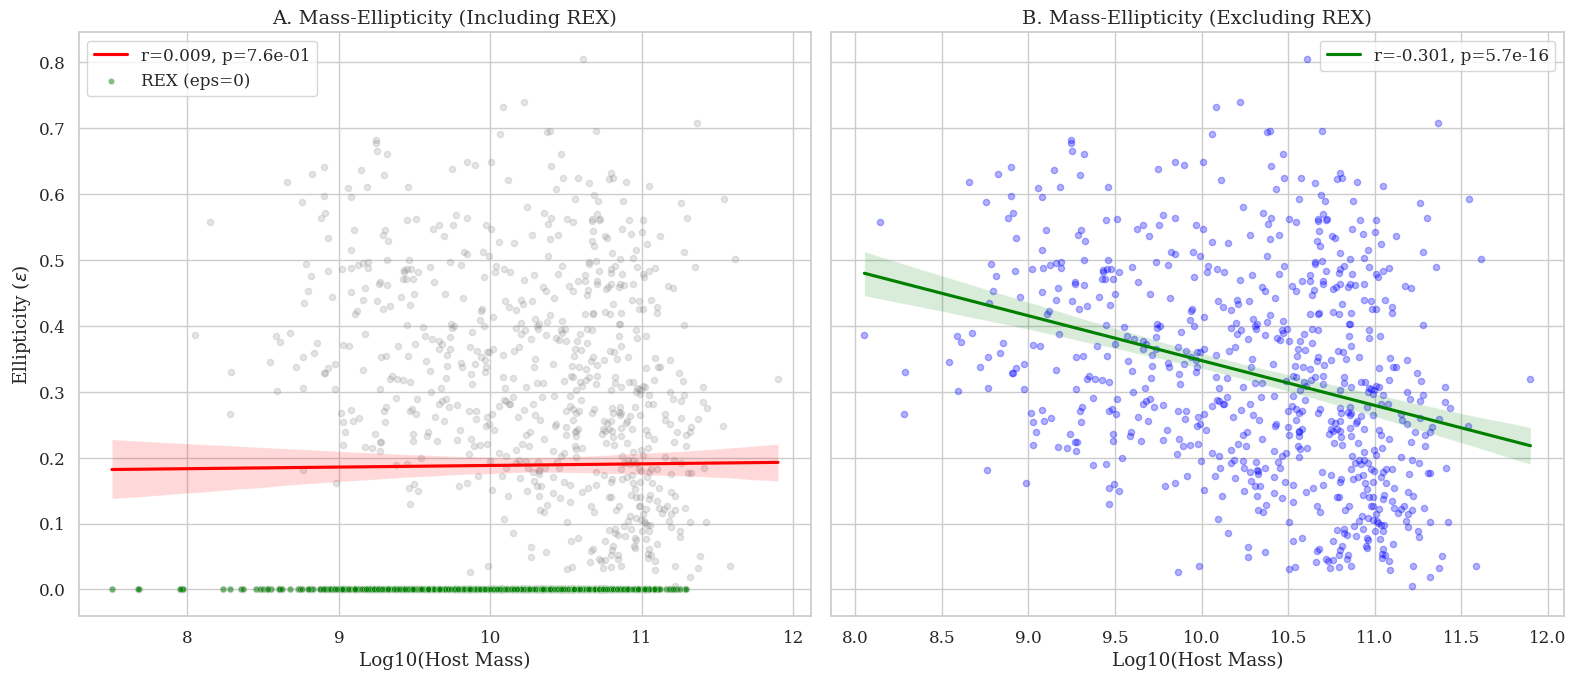

全样本相关性: r = 0.0088, p = 7.6020e-01
排除REX相关性: r = -0.3009, p = 5.7238e-16


In [18]:

# --- 1. 数据提取 ---
mass_list, ellip_list, type_list = [], [], []

for host in valid_host_galaxies:
    sn_idx = host['ID'][0]
    mass = SN_sample['HOSTGAL_LOGMASS'][sn_idx]
    
    # 计算椭率
    e1, e2 = host['shape_e1'][0], host['shape_e2'][0]
    eps = np.sqrt(e1**2 + e2**2)
    
    # 清洗类型标签
    h_type = host['type'][0]
    if isinstance(h_type, bytes): h_type = h_type.decode('utf-8').strip()
    
    # 过滤无效质量数据
    if mass > 0 and 0 <= eps <= 1.0:
        mass_list.append(mass)
        ellip_list.append(eps)
        type_list.append(h_type)

df_corr = pd.DataFrame({
    'log_mass': mass_list,
    'ellipticity': ellip_list,
    'type': type_list
})

# 创建排除 REX 的子集
df_no_rex = df_corr[df_corr['type'] != 'REX'].copy()

# 计算相关系数
r_all, p_all = stats.pearsonr(df_corr['log_mass'], df_corr['ellipticity'])
r_no_rex, p_no_rex = stats.pearsonr(df_no_rex['log_mass'], df_no_rex['ellipticity'])

# --- 2. 绘图对比 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# 左图：全样本 (包含 REX)
sns.regplot(x='log_mass', y='ellipticity', data=df_corr, ax=axes[0], 
            scatter_kws={'alpha':0.2, 's':20, 'color':'gray'}, 
            line_kws={'color':'red', 'label':f'r={r_all:.3f}, p={p_all:.1e}'})
# 突出显示 REX 的点
sns.scatterplot(x='log_mass', y='ellipticity', data=df_corr[df_corr['type']=='REX'], 
                ax=axes[0], color='green', label='REX (eps=0)', s=20, alpha=0.5)
axes[0].set_title('A. Mass-Ellipticity (Including REX)', fontsize=14)
axes[0].set_xlabel('Log10(Host Mass)')
axes[0].set_ylabel(r'Ellipticity ($\epsilon$)')
axes[0].legend()

# 右图：排除 REX (仅包含有测量形状的星系)
sns.regplot(x='log_mass', y='ellipticity', data=df_no_rex, ax=axes[1], 
            scatter_kws={'alpha':0.3, 's':20, 'color':'blue'}, 
            line_kws={'color':'green', 'label':f'r={r_no_rex:.3f}, p={p_no_rex:.1e}'})
axes[1].set_title('B. Mass-Ellipticity (Excluding REX)', fontsize=14)
axes[1].set_xlabel('Log10(Host Mass)')
axes[1].set_ylabel('') # 共享 y 轴不需要重复标签
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 3. 结果打印 ---
print(f"全样本相关性: r = {r_all:.4f}, p = {p_all:.4e}")
print(f"排除REX相关性: r = {r_no_rex:.4f}, p = {p_no_rex:.4e}")